# Simulación virtual de contagio adaptado al COVID-19

Este estudio tiene la finalidad de presentar los resultados de una simulación virtual sobre un modelo de contagio adaptado al COVID-19. Concretamente se han simulado dos escenarios de contagio distintos:

- En el primero de ellos muestra una situación normal, sin medidas de prevención en cuanto a la libre circulación de personas.

- En el segundo se intenta reflejar una situación con estado de alarma, en este caso se reduce la circulación de personas y por lo tanto las exposiciones con los individuos de su entorno. 

Descripción del **algoritmo** y parámetros utilizados:

1. Creación de una población virtual (10 millones de habitantes).
2. Generación de relaciones entre los individuos, serán los canales que utilizará el virus para propagarse. En el primero de los escenarios las relaciones entre individuos serán de 1 a 15 relaciones y el segundo de 1 a 5 relaciones diarias.
3. Se contagia al azar a 3 individuos.
4. Se simulará día a día, en cada día los individuos contagiados podrán transferir el virus con una probabilidad del 10% a aquellos con los que se hayan relacionado. 
5. Una vez contagiado un individuo entra en un periodo de incubación de dos días. Durante la incubación el individuo no podrá contagiar. A los 15 días de contagiarse cada individuo para curarse con un 90% de probabilidad o fallecer. Los individuos que superen la enfermedad no pueden volver a ser contagiados.
6. El algoritmo para cuanto ningún miembro de la población está contagiado.

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Genera los individuos de la población

In [3]:
# Genera un listado de personas
# En función de la variable prob_inmune esta población será más o menos resistente al virus.

def generaPoblacion():
    
    poblacion = []

    for i in range (tam_poblacion):
        
        #Aqui definimos si el individuo de la población es inmune
        if random.random() <= prob_inmune: 
            estado = 1 #Inmune
        else: 
            estado = 0 #Susceptible de contagio
            
        persona = {"Id": i, 
                   "Estado": estado, 
                   "Dias_Contagiado": -1, 
                   #"Dia_Contagio":-1, 
                   #"Usuario_Contagia": -1
                  }
        
        poblacion.append(persona)
    
    return poblacion

### Genera las relaciones entre la población

In [4]:
#Relaciones entre las personas
def generaRelaciones():
   
    relaciones = []

    for i in range (tam_poblacion):
        relacion = []
        #Cada persona se relaciona con otras un número aleatorio de veces
        num_relaciones = random.randint(num_relaciones_min, num_relaciones_max)
    
        for j in range(num_relaciones):    
            index = random.randint(0, tam_poblacion-1)
            
            #Control para no relacionar consigo mismo
            while index == i:
                index = random.randint(0, tam_poblacion-1)
            relacion.append(index)
            
        relaciones.append(relacion)
    
    return relaciones

### Infectamos individuos al azar 

In [5]:
def inicializaContagios(poblacion):
    for i in range(num_infectados_init):
        poblacion[random.randint(0, tam_poblacion-1)]['Estado'] = 2
    
    return poblacion

### Simulación

In [22]:
def simulacion(poblacion, relaciones):
    resultados = []

    for dia in range(num_iteraciones):
    
        positivos = 0
        negativos = 0
        curados = 0
        fallecidos = 0
    
        for i in range(tam_poblacion):
        
            #Negativo
            if poblacion[i]['Estado'] == 0 or poblacion[i]['Estado'] == 1:
                negativos  += 1
            
            #Positivo
            elif poblacion[i]['Estado'] == 2:
                positivos += 1
                poblacion[i]['Dias_Contagiado'] += 1 
            
                #Incubación
                if poblacion[i]['Dias_Contagiado'] >= num_dias_incubacion:
            
                    #Las presonas relacionadas
                    for relacion in relaciones[i]:
                        #Si la probabilidad de contagio es mayor que un número al azar se contagia
                        if poblacion[relacion]['Estado'] == 0 and random.random() < prob_contagio:
                            poblacion[relacion]['Estado'] = 2
                            poblacion[relacion]['Dias_Contagiado'] = 0
                            #poblacion[relacion]['Dia_Contagio'] = dia
                            #poblacion[relacion]['Usuario_Contagia'] = i
                        
                    if poblacion[i]['Dias_Contagiado'] > num_dias_cura:
                        if random.random() <= prob_cura:
                            poblacion[i]['Estado'] = 3
                        else:
                            poblacion[i]['Estado'] = 4
            #Inmune(Curado)   
            elif poblacion[i]['Estado'] == 3:
                curados += 1
            #Fallecido
            elif poblacion[i]['Estado'] == 4:
                fallecidos += 1
            
    
        resultado = {"dia": dia, "positivos": positivos, "negativos": negativos, "curados":curados, "fallecidos":fallecidos}
        resultados.append(resultado)
        
        # Si no hay positivos detenemos la simulación
        if positivos == 0:
            break;

    return pd.DataFrame(resultados)

### Guarda los resultados para su posterior análisis

In [14]:
def guardarExcel(resultados, nombreFichero):
    writer = pd.ExcelWriter(nombreFichero)
    resultados.to_excel(writer,'Resultados')
    writer.save()

### Generamos los gráficos

In [15]:
def generaGraficosLineas(resultados, nombreFichero, titulo):
    ax = plt.subplots(figsize=(20,12))

    plt.plot(resultados.dia, resultados.fallecidos, color = '#d62729', label = 'Fallecidos')
    plt.plot(resultados.dia, resultados.positivos, color = '#ff7f0d', label = 'Positivos')
    plt.plot(resultados.dia, resultados.negativos, color = '#1f77b4', label = 'Negativos')
    plt.plot(resultados.dia, resultados.curados, color = '#2ca02c', label = 'Curados')
                
    plt.legend(loc='upper left')

    plt.xticks(fontsize='20')
    plt.yticks(fontsize='20')

    plt.legend(prop = {'size':20}, 
               loc = 'upper center', 
               bbox_to_anchor=(1.1, 1))
    
    plt.xlabel("Días", fontsize=20, labelpad=10)
    plt.ylabel("Población", fontsize=20, labelpad=10)
    plt.title(titulo, fontsize=25, loc='center', pad=20)
    plt.savefig(nombreFichero, bbox_inches = "tight")
    plt.show()

In [16]:
def generaGraficosAcumulado(resultados, nombreFichero, titulo):
    ax = plt.subplots(figsize=(20,12))

    plt.stackplot(resultados.dia, resultados.fallecidos, 
                resultados.positivos, resultados.negativos, 
                resultados.curados, 
                labels = ['Fallecidos', 'Positivos', 'Negativos', 'Curados'],
                colors=['#d62729', '#ff7f0d', '#1f77b4', '#2ca02c'])
    plt.legend(loc='upper left')

    plt.xticks(fontsize='20')
    plt.yticks(fontsize='20')

    plt.legend(prop = {'size':20}, 
               loc = 'upper center', 
               bbox_to_anchor=(1.1, 1))
    
    plt.xlabel("Días", fontsize=20, labelpad=10)
    plt.ylabel("Población", fontsize=20, labelpad=10)
    plt.title(titulo, fontsize=25, loc='center', pad=20)
    plt.savefig(nombreFichero, bbox_inches = "tight")
    plt.show()

### Parámetros de la simulación adaptados al COVID-19

In [53]:
#Tamaño total de la población
#tam_poblacion = 46723749
tam_poblacion = 10000000

#Número mínimo y máximo de personas con las que se tiene contacto en un día
num_relaciones_min = 1
num_relaciones_max = 12

#Número de infectados al inicio (Día 0)
num_infectados_init = 3

#Número de días de la simulación
num_iteraciones = 400

#Probabilidad de contagio teniendo contacto con una persona contagiada
prob_contagio = 0.1

# % de población inmune al virus
prob_inmune = 0.33

#Probabilidad de supervivencia al virus (Cura)
prob_cura = 0.9

#Número de días necesario volverse inmune al virus (Cura) o fallecer
num_dias_cura = 15

#Número de días de incubación (Durante estos días no se puede contagiar)
num_dias_incubacion = 2

#Posibles estados de cada individuo de la población
#0 -> Negativo
#1 -> Inmune
#2 -> Positivo
#3 -> Curado
#4 -> Fallecido

## Ejecución del algoritmo

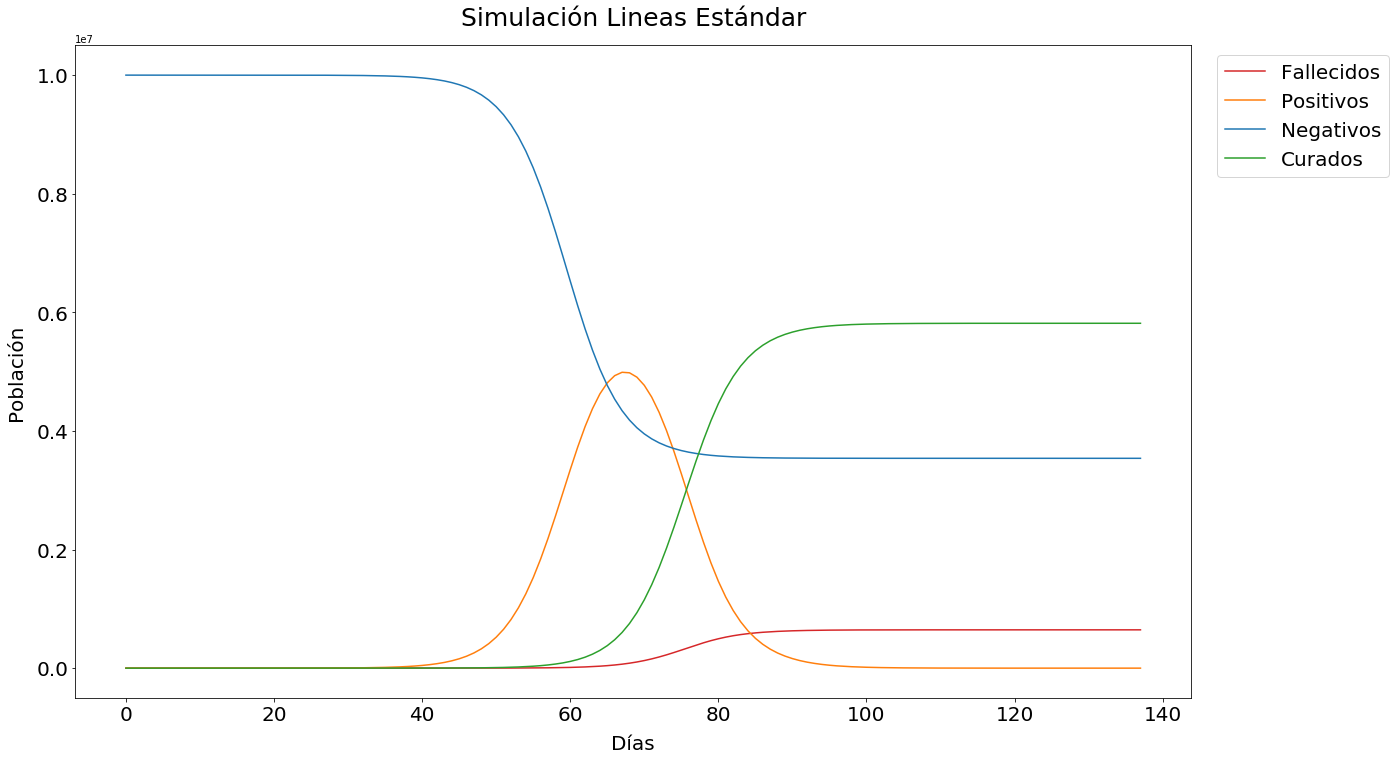

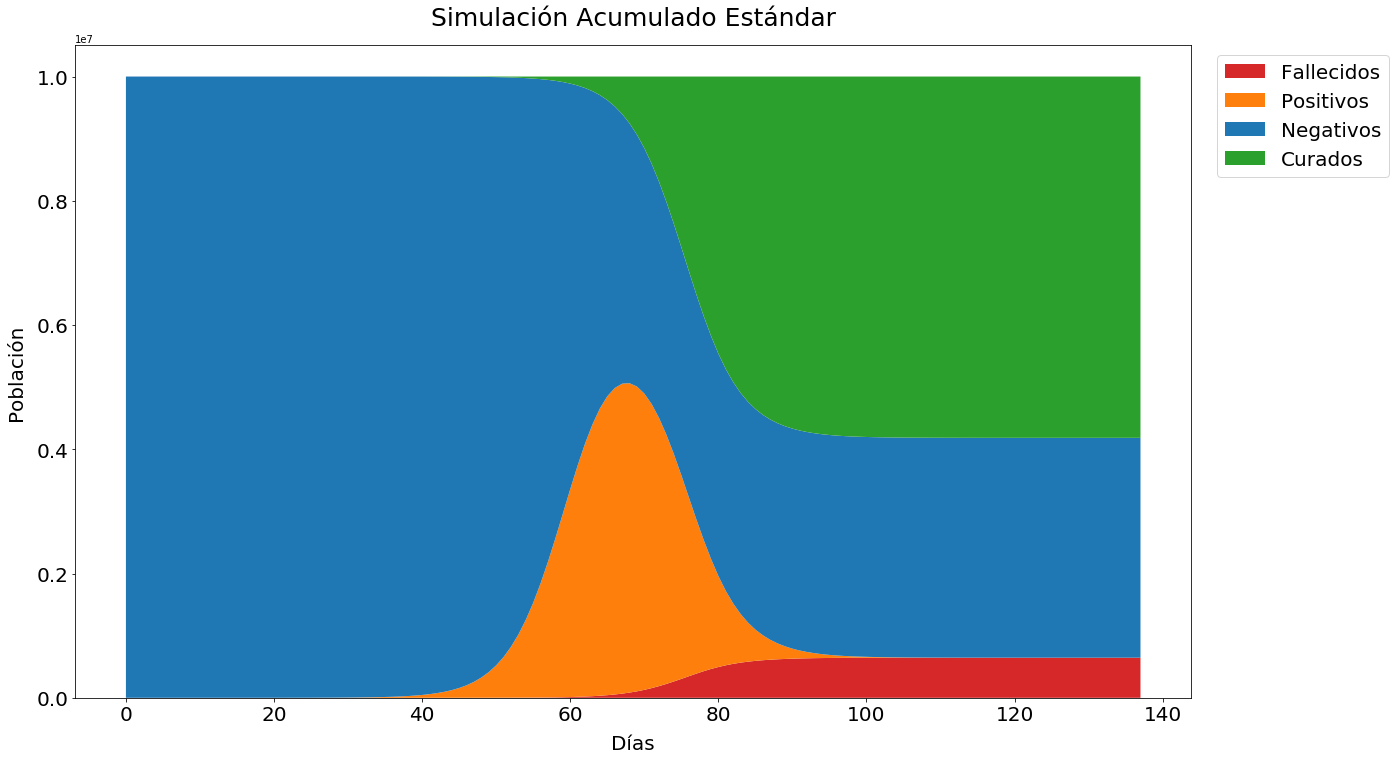

In [47]:
#Genera los individuos de la población
poblacion = generaPoblacion()

#Relaciones entre las personas 
relaciones = generaRelaciones()

#Inicializa contagios
poblacion = inicializaContagios(poblacion)

#Simulación
resultados = simulacion(poblacion, relaciones)

#Guardamos los resultados para su posterior estudio
guardarExcel(resultados, 'Resultados.xlsx')

#Generamos los gráficos
generaGraficosLineas(resultados, 'SimulaciónEstandar_L.png', 'Simulación Lineas Estándar')
generaGraficosAcumulado(resultados, 'SimulaciónEstandar_A.png', 'Simulación Acumulado Estándar')

## Repetimos el experimento pero esta vez reducimos las interacciones con personas #QuedateEnCasa

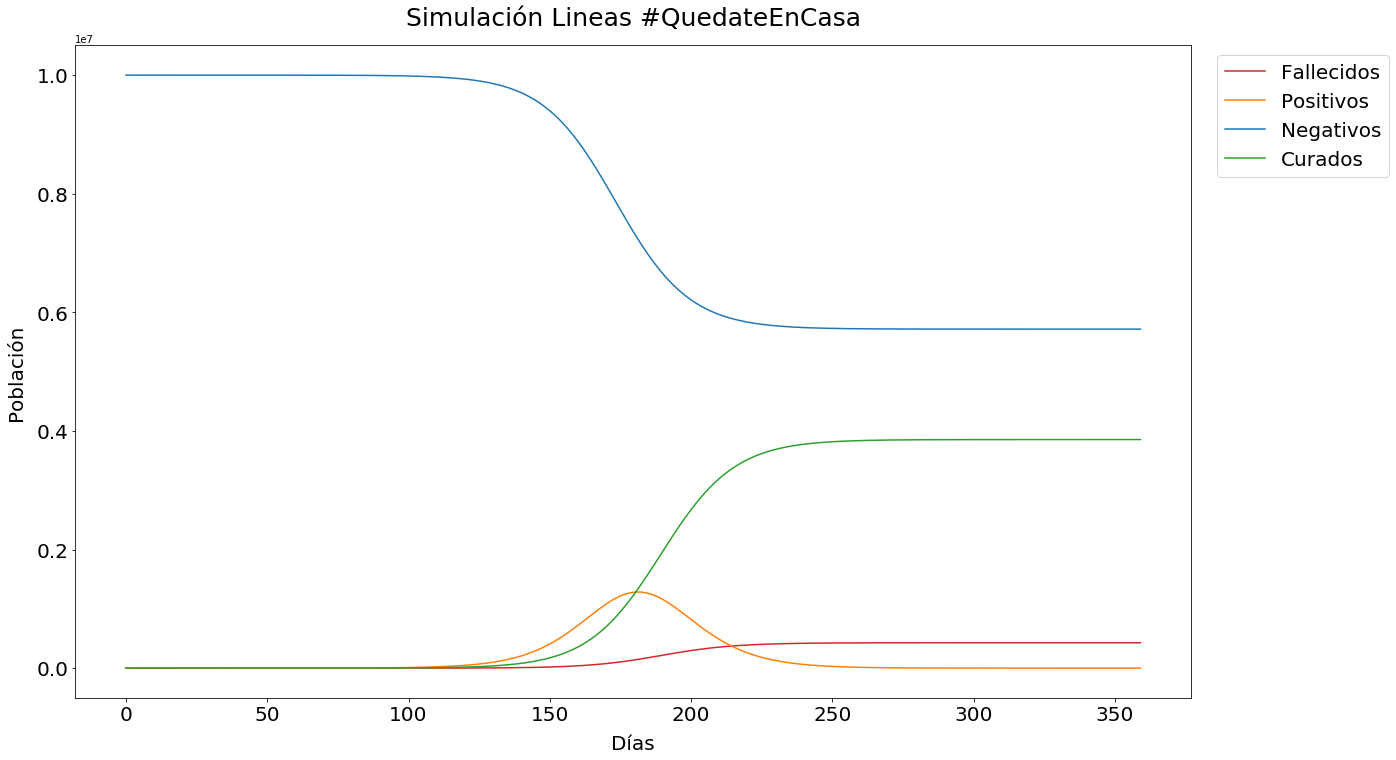

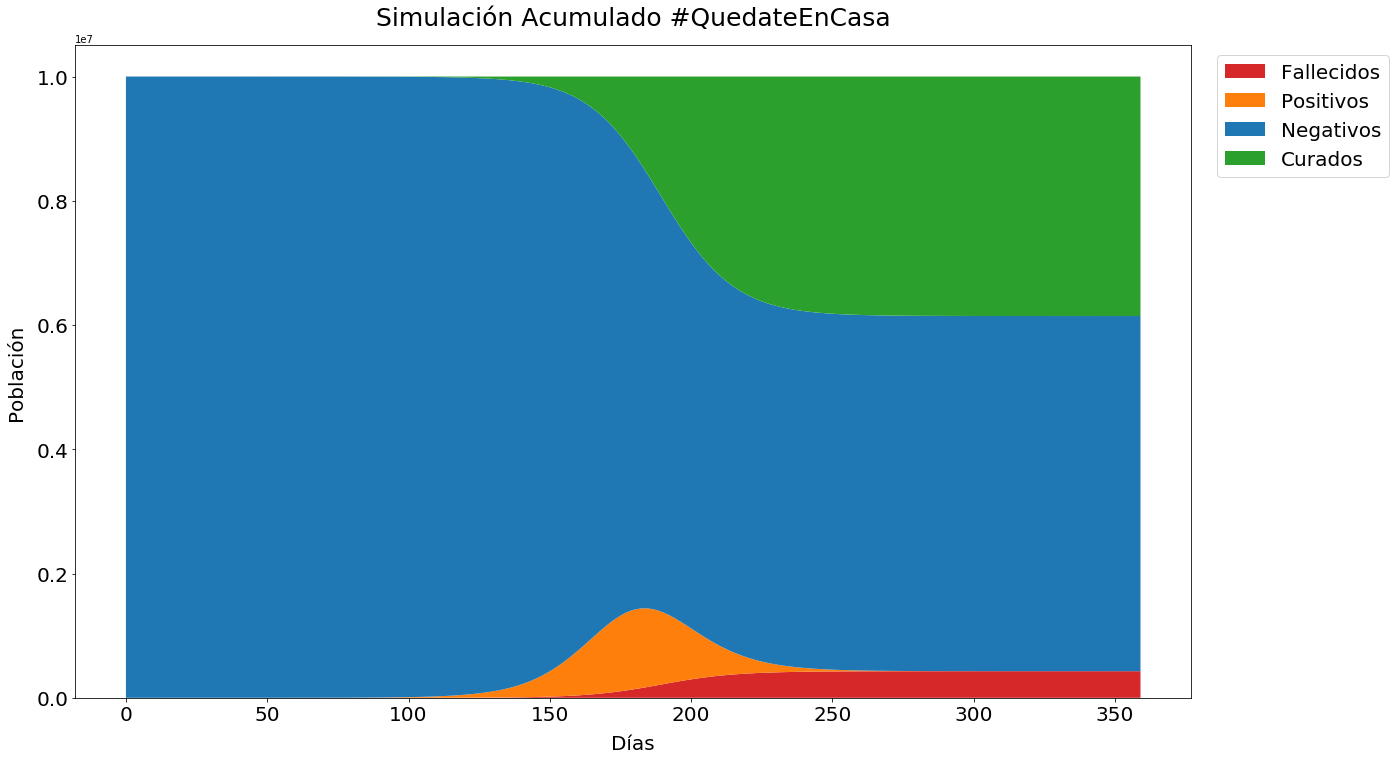

In [54]:
num_relaciones_min = 1
num_relaciones_max = 5

#Genera los individuos de la población
poblacion2 = generaPoblacion()

#Relaciones entre las personas, está vez menos relaciones al establecerse la cuarentena #QuedateEnCasa
relaciones2 = generaRelaciones()

#Inicializa contagios
poblacion2 = inicializaContagios(poblacion2)

#Simulación
resultados2 = simulacion(poblacion2, relaciones2)

#Guardamos los resultados para su posterior estudio
guardarExcel(resultados2, 'Resultados2.xlsx')

#Generamos los gráficos
generaGraficosLineas(resultados2, 'SimulaciónQuedateEnCasa_L.png', 'Simulación Lineas #QuedateEnCasa')
generaGraficosAcumulado(resultados2, 'SimulaciónQuedateEnCasa_A.png', 'Simulación Acumulado #QuedateEnCasa')